In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import re
import copy
from langdetect import detect
from textblob import TextBlob

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [6]:
calendar = pd.read_csv("calendar.csv")

In [7]:
listings = pd.read_csv("listings.csv")

In [8]:
reviews = pd.read_csv("reviews.csv")

# Calendar Dataset

In [9]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [10]:
calendar.shape

(1393570, 4)

In [11]:
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [12]:
calendar['date']=pd.to_datetime(calendar.date)
calendar['weekday'] =calendar['date'].dt.weekday
calendar['month'] =calendar['date'].dt.month

calendar['price']=calendar.price.fillna('-1').apply(lambda x: re.sub('[\$|\.00|\,]','', x)).astype('int')

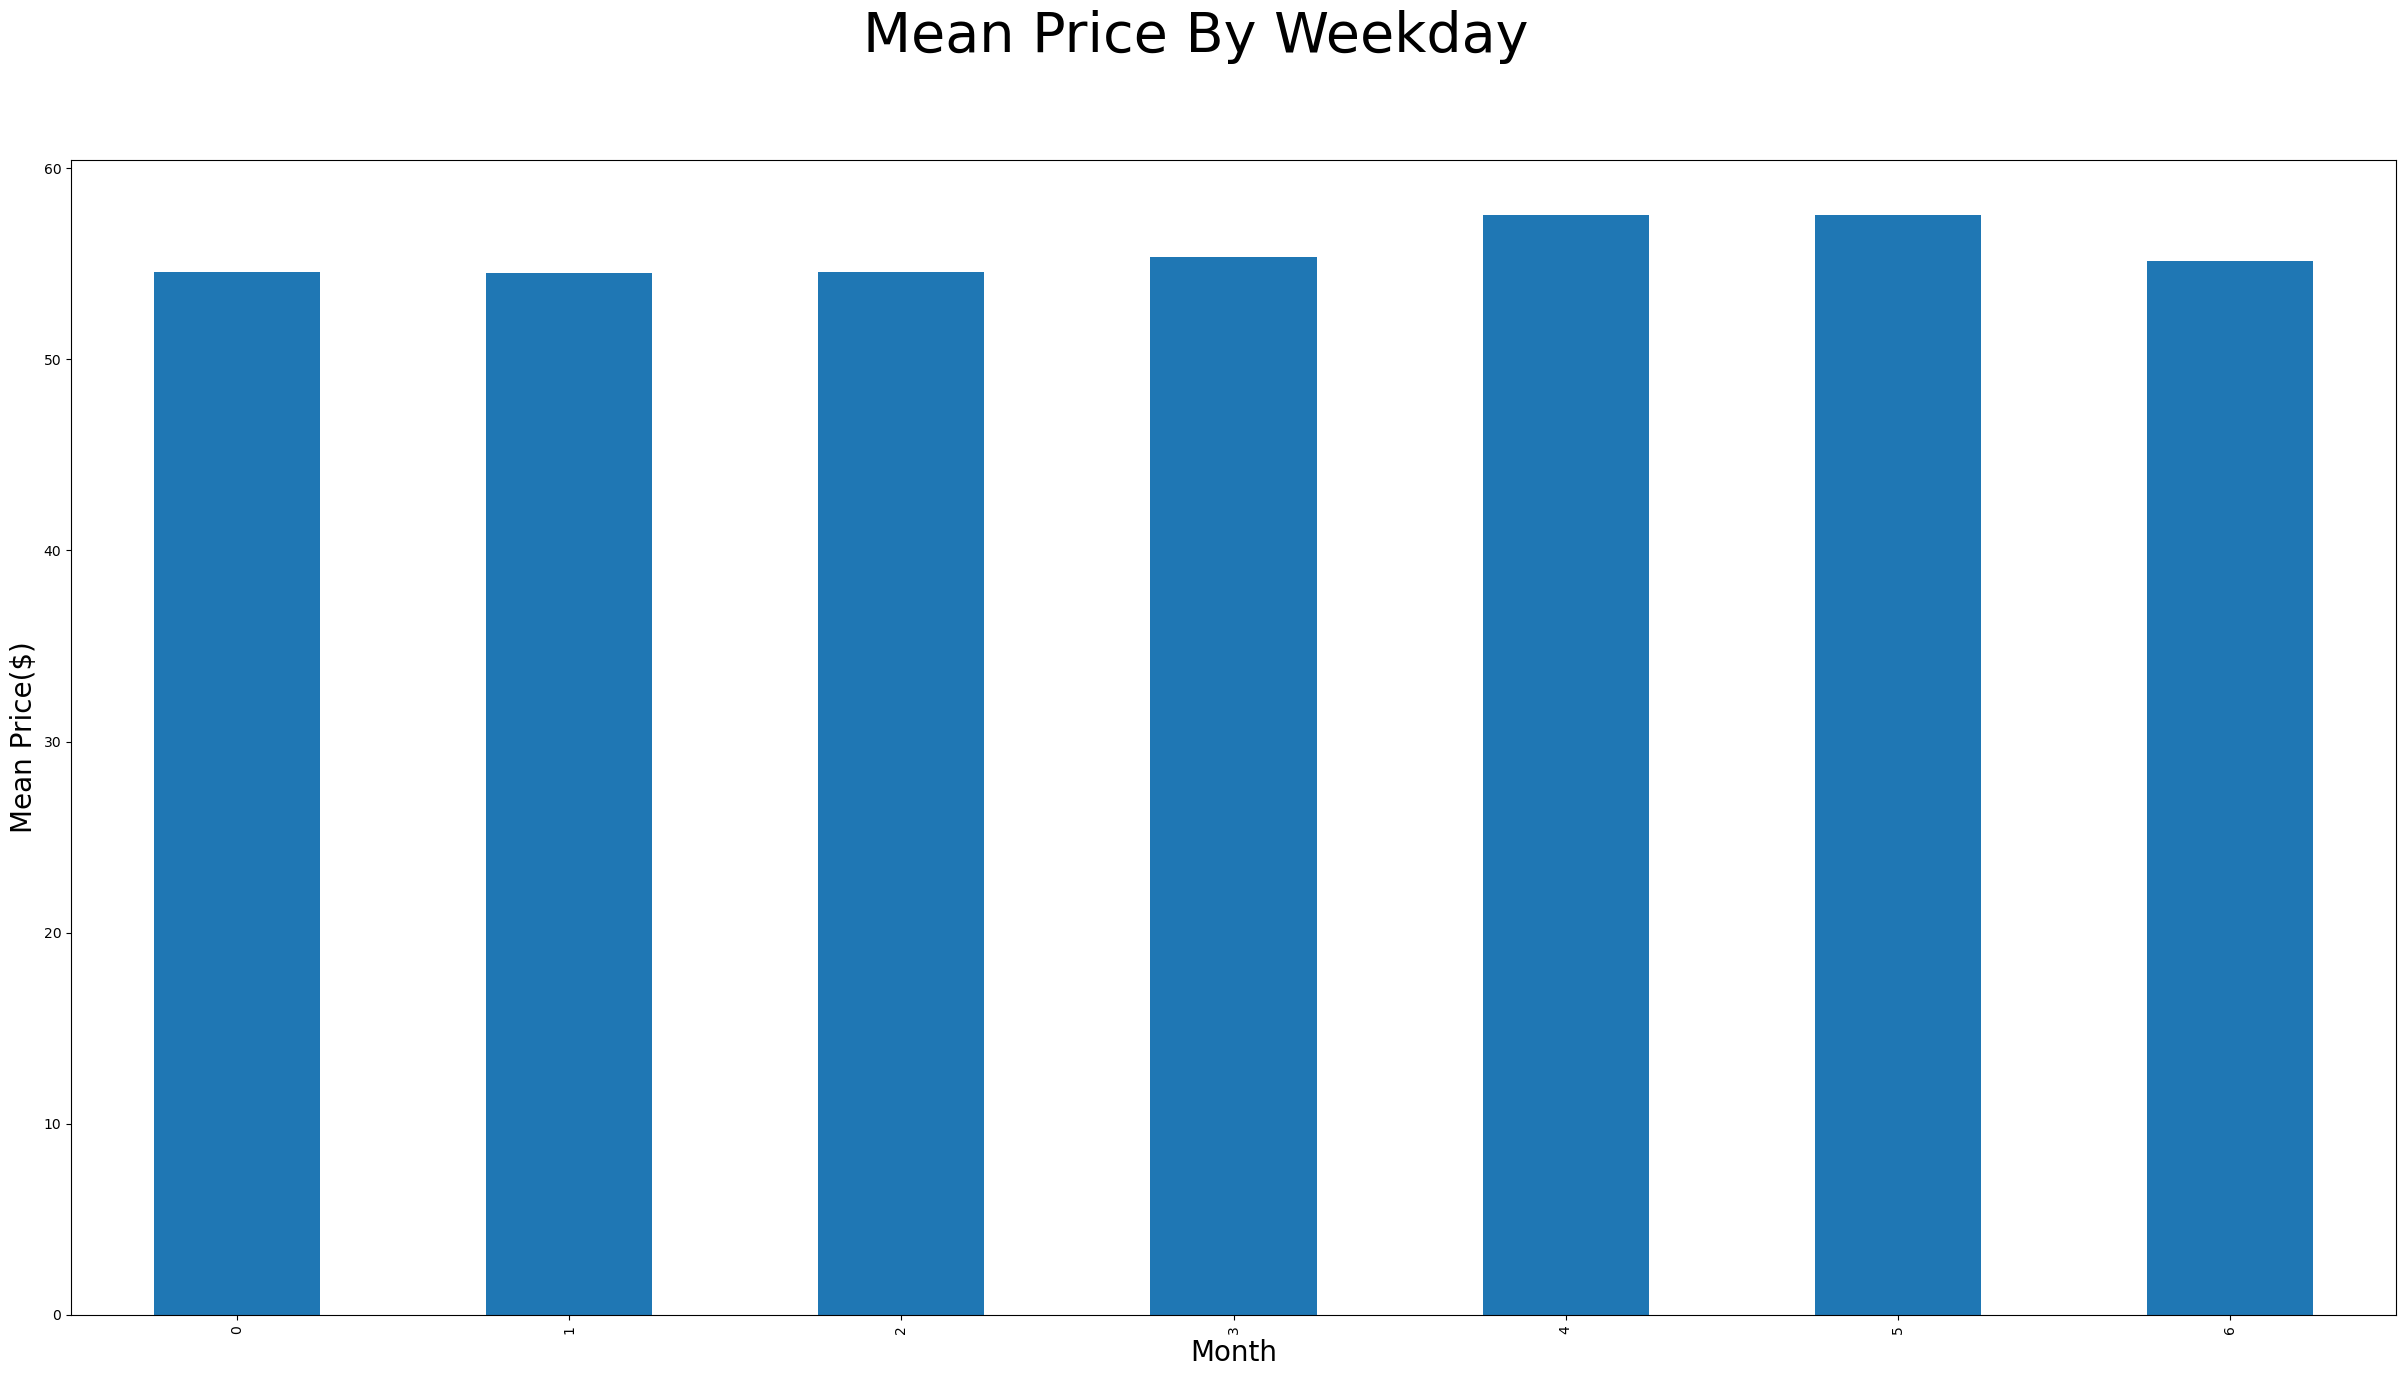

In [74]:
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
# 5 is saturday
calendar.groupby(['weekday']).price.mean().plot.bar()
t =fig.suptitle('Mean Price By Weekday', fontsize=40)
a=ax.set_xlabel('Month',fontsize=20)
b =ax.set_ylabel('Mean Price($)',fontsize=20)
# save the plot as png.
plt.savefig('mean_price_by_Weekday.png')

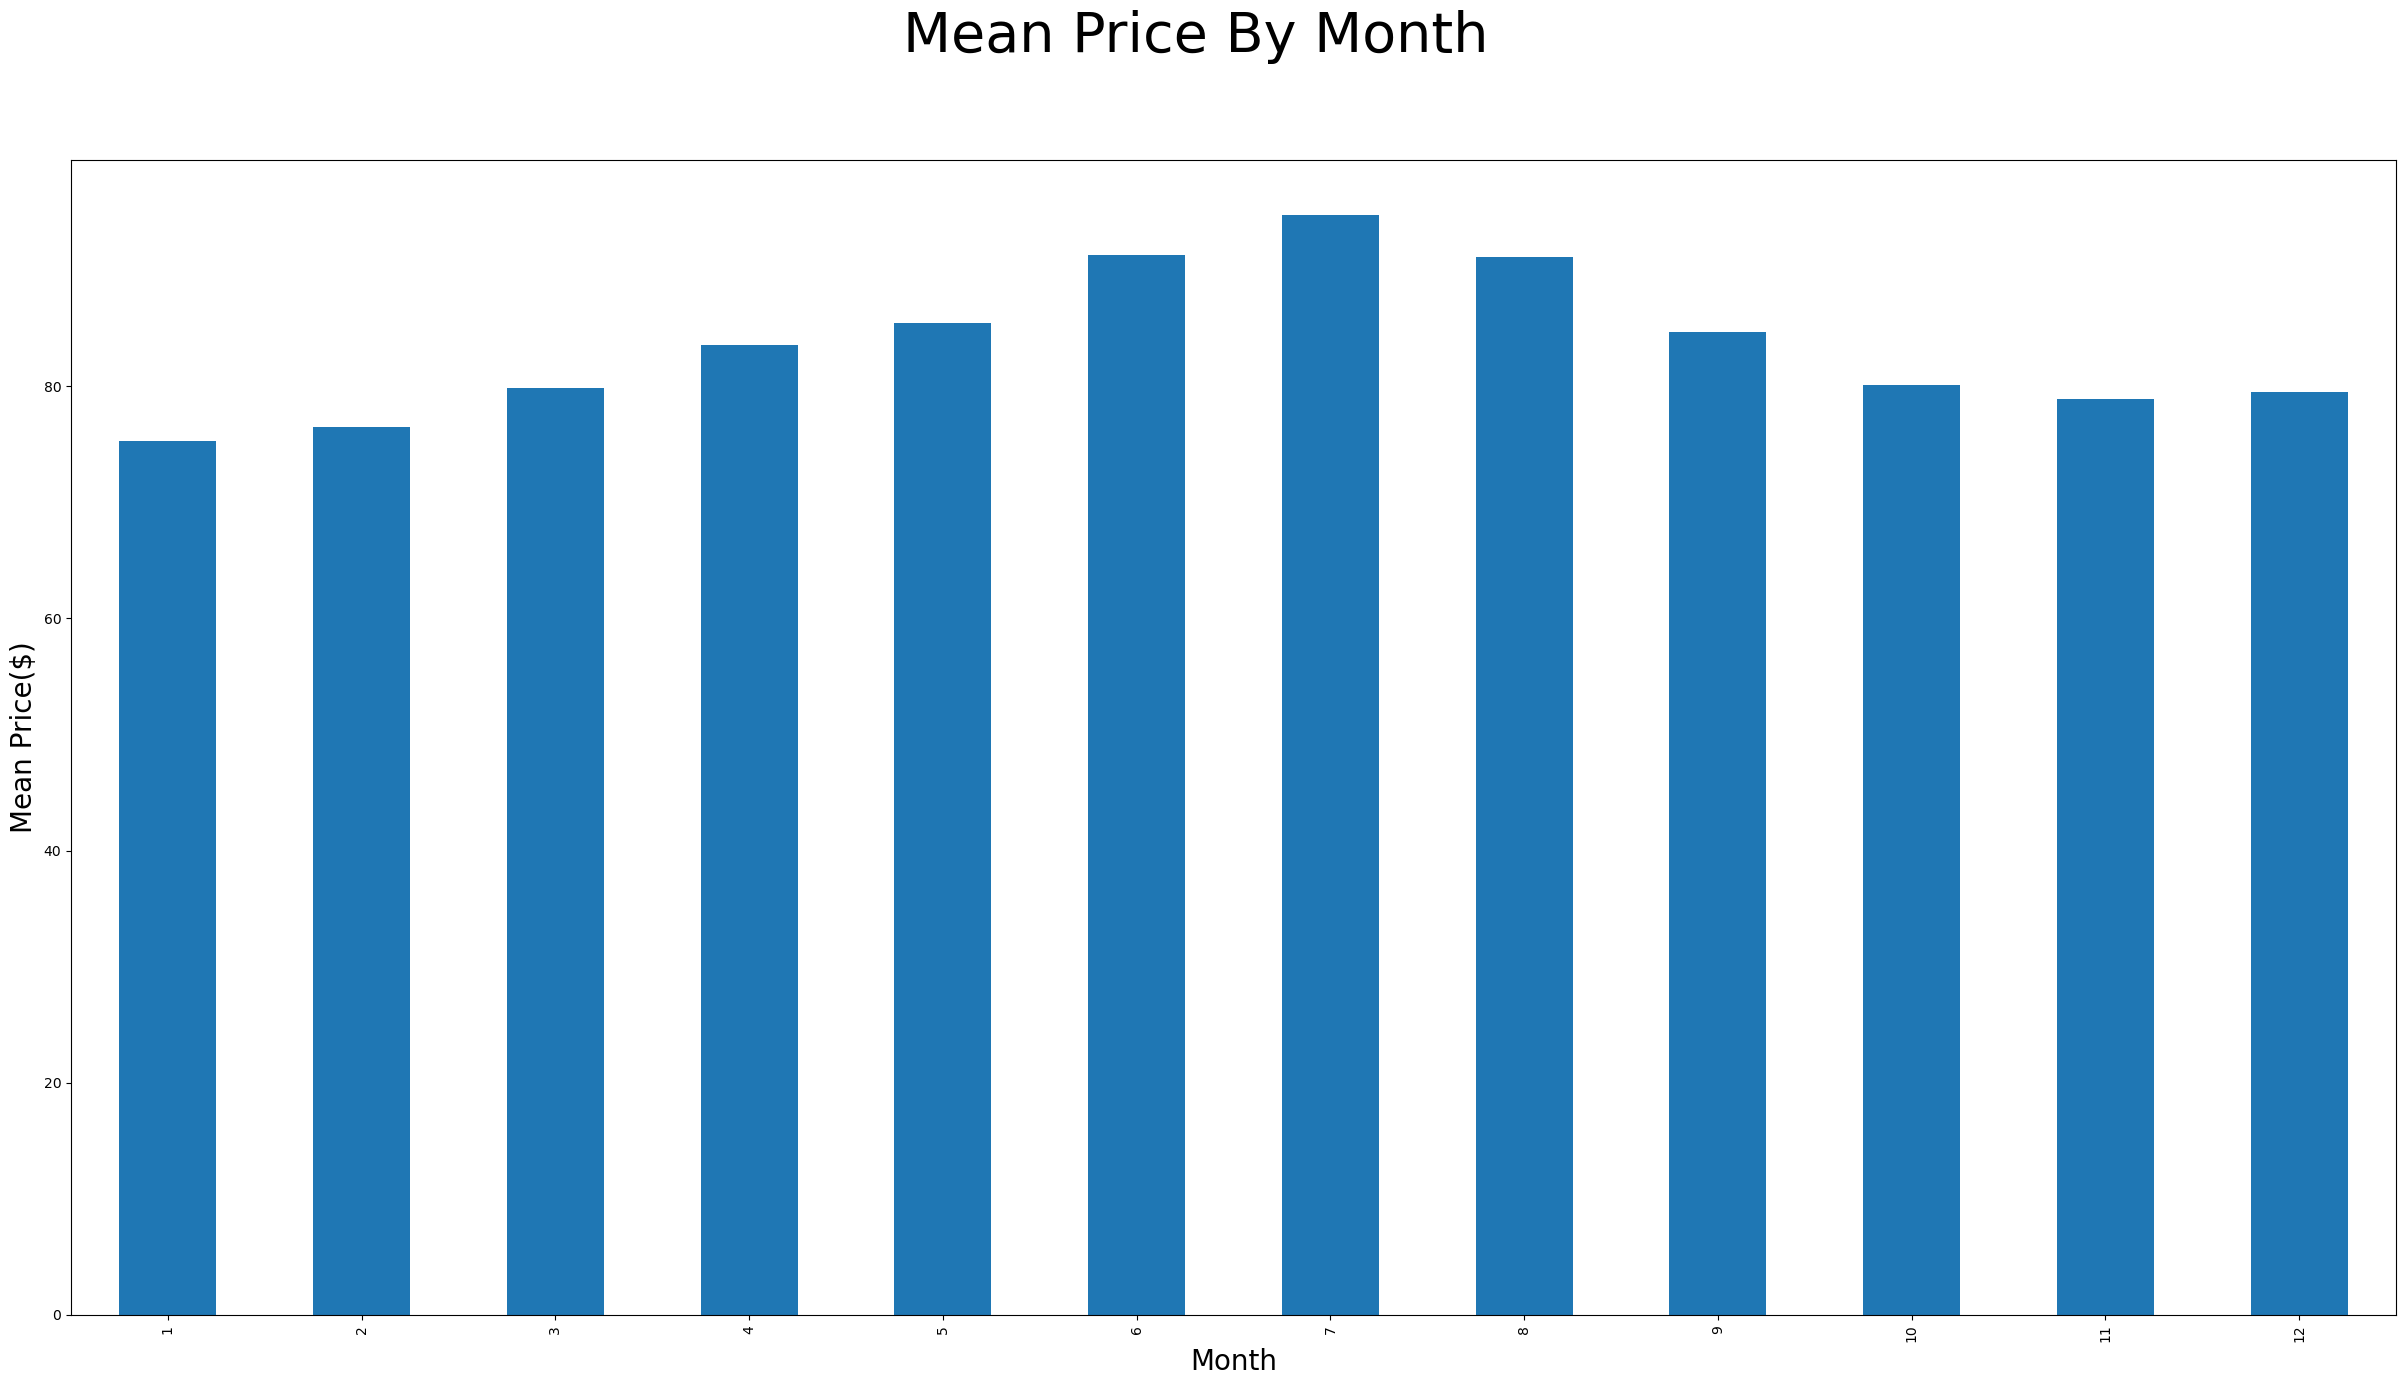

In [75]:
calendar = calendar.loc[calendar.price!=-1,:]
fig = plt.figure(figsize=(30,15))
ax = fig.gca()

calendar.groupby(['month']).price.mean().plot.bar()
t =fig.suptitle('Mean Price By Month', fontsize=40)
a=ax.set_xlabel('Month',fontsize=20)
b =ax.set_ylabel('Mean Price($)',fontsize=20)
# save plot as png
plt.savefig('mean_price_by_month.png')

# Listings Dataset

In [76]:
listings.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,Treehouse,Yurt,Private room,Shared room,Couch,Futon,Pull out Sofa,Real Bed,moderate,strict
0,956883,96,100,0,3.0,1,1,47.636289,-122.371025,1,...,0,0,0,0,0,0,0,1,1,0
1,5177328,98,100,1,6.0,1,1,47.639123,-122.365666,1,...,0,0,0,0,0,0,0,1,0,1
2,16708587,67,100,0,2.0,1,1,47.629724,-122.369483,1,...,0,0,0,0,0,0,0,1,0,1
3,9851441,0,0,0,1.0,1,1,47.638473,-122.369279,1,...,0,0,0,0,0,0,0,1,0,0
4,1452570,100,0,0,2.0,1,1,47.632918,-122.372471,1,...,0,0,0,0,0,0,0,1,0,1


In [77]:
# listings.columns.tolist()

In [78]:
listings.shape

(3818, 127)

In [79]:
listings.isnull().sum()

host_id                      0
host_response_rate           0
host_acceptance_rate         0
host_is_superhost            0
host_total_listings_count    2
                            ..
Futon                        0
Pull out Sofa                0
Real Bed                     0
moderate                     0
strict                       0
Length: 127, dtype: int64

# Reviews Dataset

In [80]:
reviews.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,polarity
0,0,7202016,38917982,2015-07-19,28943674,Bianca,cute and cozy place perfect location to every...,en,0.433333
1,1,7202016,39087409,2015-07-20,32440555,Frank,kelly has a great room in a very central locat...,en,0.301136
2,2,7202016,39820030,2015-07-26,37722850,Ian,very spacious apartment and in a great neighb...,en,0.391667
3,3,7202016,40813543,2015-08-02,33671805,George,close to seattle center and all it has to offe...,en,0.358333
4,4,7202016,41986501,2015-08-10,34959538,Ming,kelly was a great host and very accommodating ...,en,0.477576


In [81]:
reviews.shape

(83763, 9)

In [82]:
reviews.isnull().sum()

Unnamed: 0       0
listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
lang             0
polarity         0
dtype: int64

In [83]:
def detect_lang(val):
    """
    Returns language code for a given text
    :param val: text string
    :return language string 
    """
    try:
        return detect(val)
    except:
        return ''

# detect language for all comments and create a column to store language
# reviews['lang'] = reviews['comments'].apply(lambda val: detect_lang(val))

In [84]:
# ignore columns that language couldn't be detected
# reviews = reviews.loc[reviews.lang!='',:]

In [85]:
# display number of comments that are not English
# reviews[reviews.lang!='en'].shape[0]/reviews.shape[0]
# take only the rows that has English comments
# reviews = reviews.loc[reviews.lang=='en',:]

In [86]:
# reviews.loc[reviews.lang!='en','comments'].head()

# Please uncomment commands below to generate the files yourself
# reviews[reviews.lang=='de'].comments.to_csv('de_comments.csv')
# reviews[reviews.lang=='fr'].comments.to_csv('fr_comments.csv')

In [87]:
# calculate polarity for comments and create a new column
# reviews['polarity'] = reviews['comments'].apply(lambda val :  TextBlob(val).sentiment.polarity )                                                                                                   
# uncomment the line below to save the results yourself.
#reviews.to_csv('data/reviews_with_polarity.csv')                                                                                                                       

**Read previously saved reviews**

In [88]:
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews_with_polarity.csv")

<Axes: xlabel='neighbourhood_group_cleansed'>

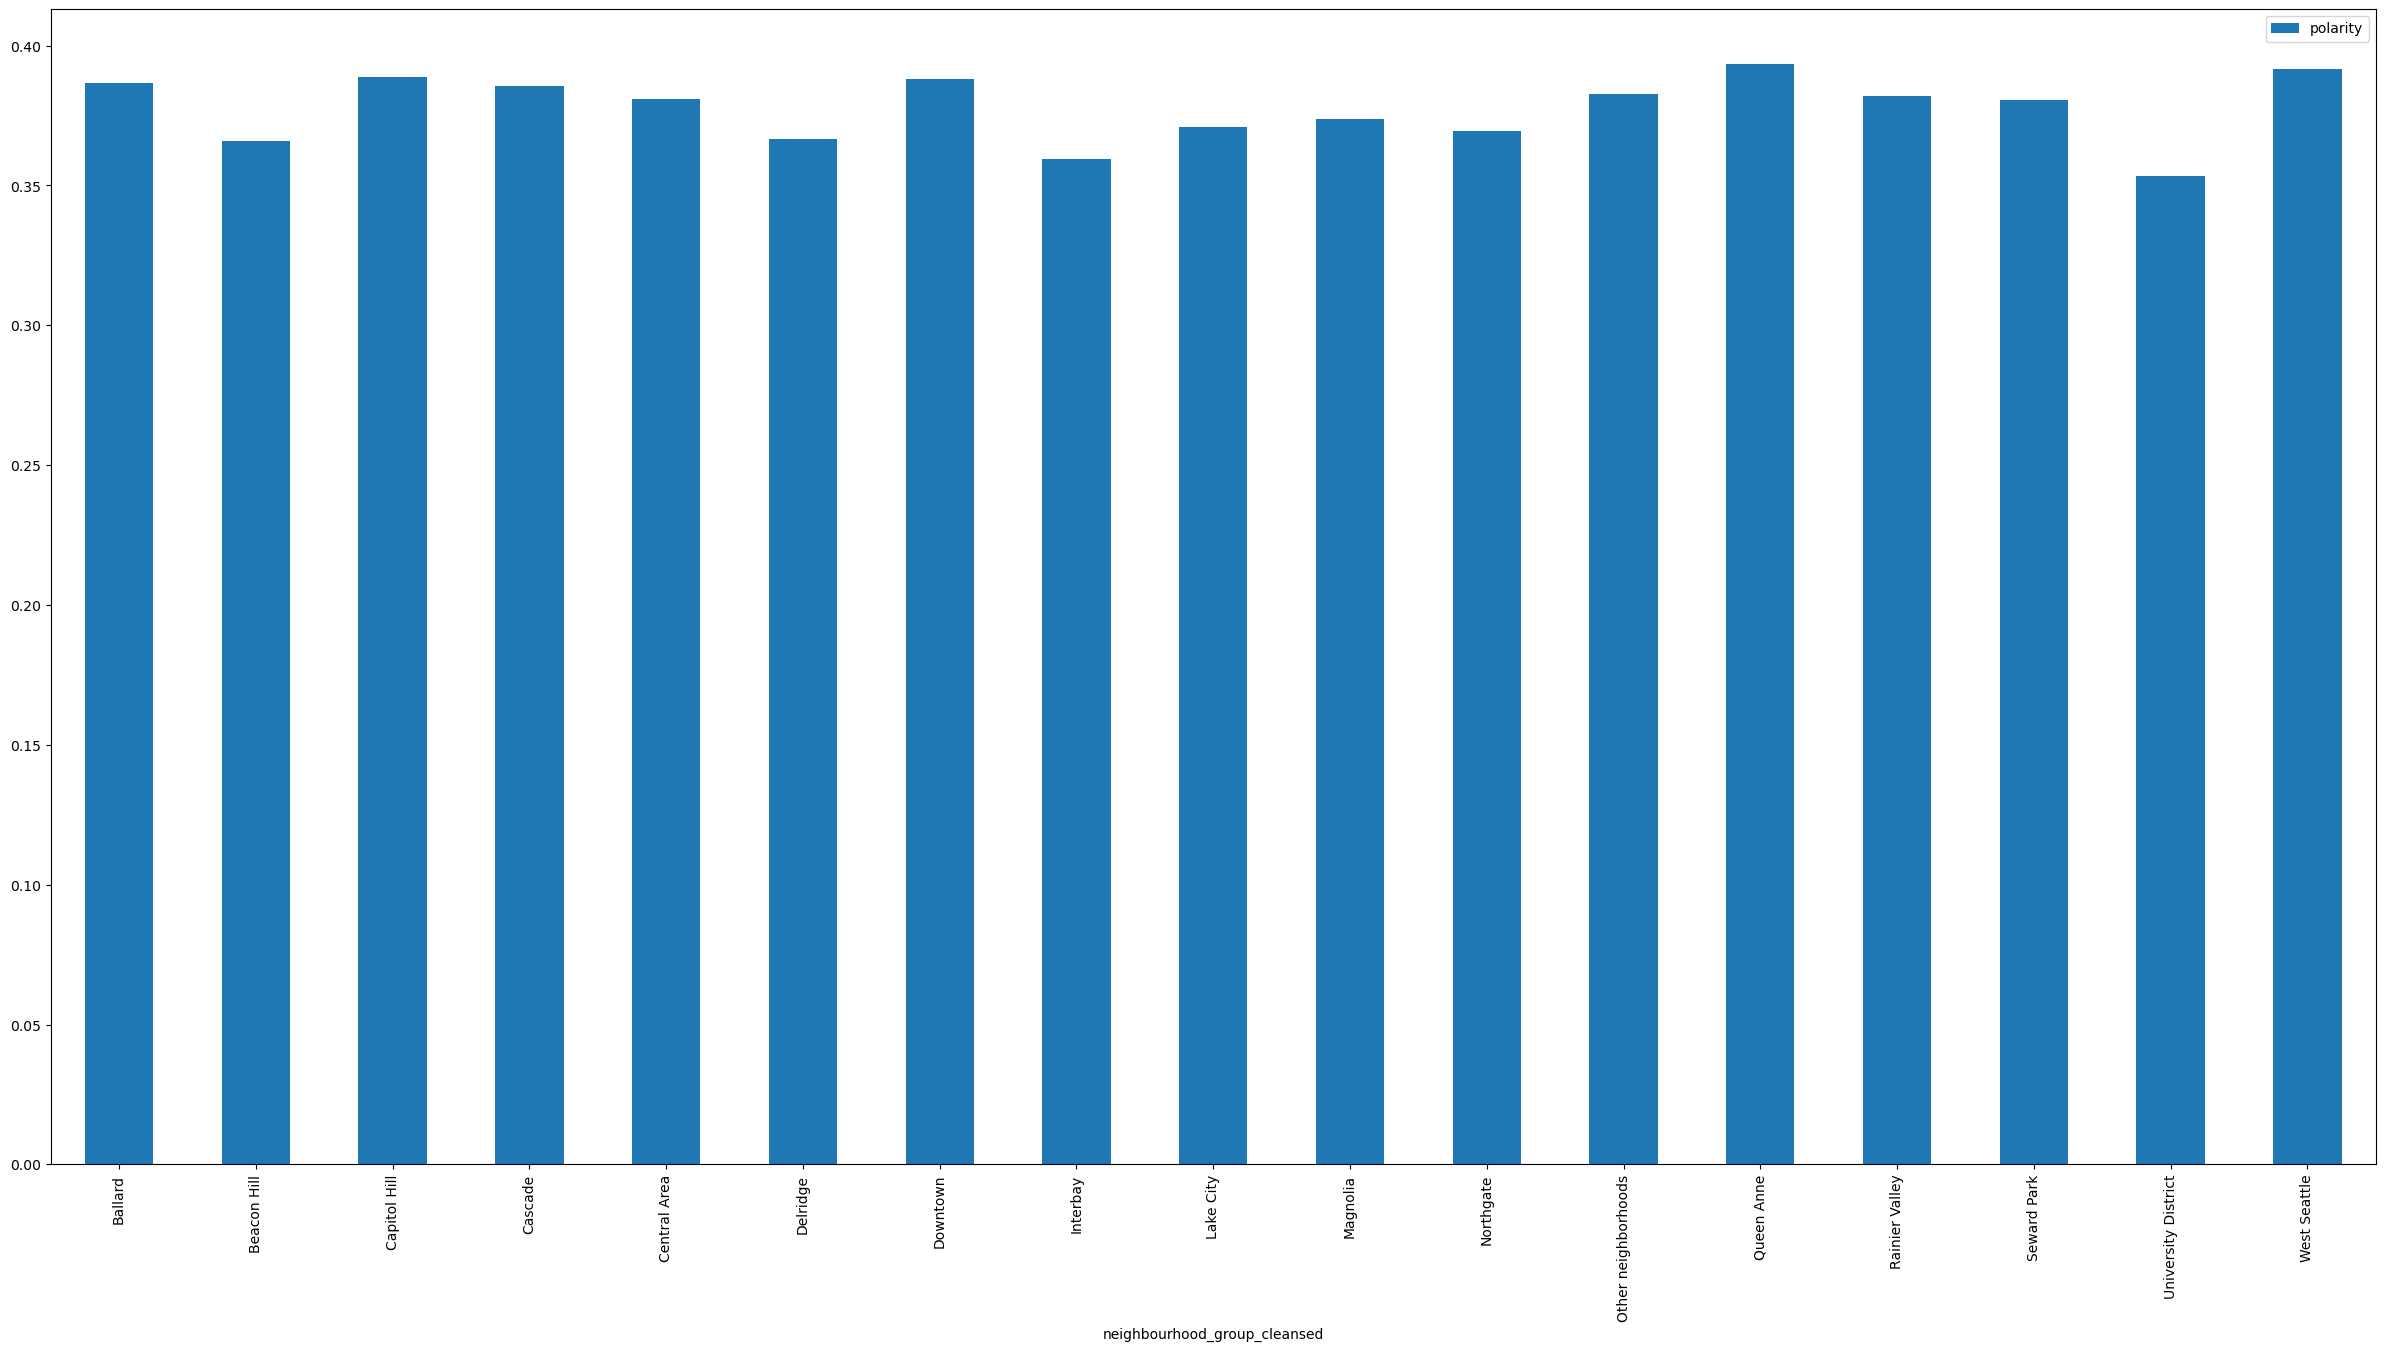

In [89]:
# get review average for each listing
reviews_ext = reviews.merge(listings, left_on='listing_id', right_on='id')

# plot comment polarity by neighbourhood_group_cleansed
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
reviews_ext.groupby(['neighbourhood_group_cleansed']).agg({'polarity':'mean'}).plot.bar(ax=ax)

# In-Depth Analysis For Listings Dataset

In [90]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


**Initial investigation shows that we can remove:**
'name', 'host_name', 'host_about','host_neighbourhood'host_listings_count	host_total_listings_count','host_verifications',host_has_profile_pic','host_identity_verified'
'scrape_id', 'last_scraped','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'


In [91]:
listings.drop(columns=['id', 'scrape_id', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], axis=1, inplace=True)

<Axes: xlabel='neighbourhood_group_cleansed'>

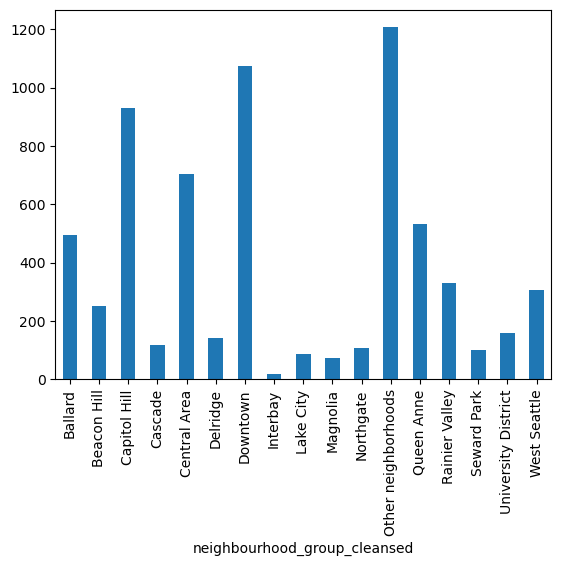

In [92]:
listings.groupby('neighbourhood_group_cleansed').reviews_per_month.sum().plot.bar()

In [93]:
numeric_columns = listings.select_dtypes(include=[np.number]).columns.tolist()
print('|\t'.join(numeric_columns))

host_id|	host_listings_count|	host_total_listings_count|	latitude|	longitude|	accommodates|	bathrooms|	bedrooms|	beds|	square_feet|	guests_included|	minimum_nights|	maximum_nights|	availability_30|	availability_60|	availability_90|	availability_365|	number_of_reviews|	review_scores_rating|	review_scores_accuracy|	review_scores_cleanliness|	review_scores_checkin|	review_scores_communication|	review_scores_location|	review_scores_value|	license|	calculated_host_listings_count|	reviews_per_month


In [94]:
# listings[numeric_columns].head()

In [95]:
listings[numeric_columns].isna().sum()/listings.shape[0]

host_id                           0.000000
host_listings_count               0.000524
host_total_listings_count         0.000524
latitude                          0.000000
longitude                         0.000000
accommodates                      0.000000
bathrooms                         0.004191
bedrooms                          0.001572
beds                              0.000262
square_feet                       0.974594
guests_included                   0.000000
minimum_nights                    0.000000
maximum_nights                    0.000000
availability_30                   0.000000
availability_60                   0.000000
availability_90                   0.000000
availability_365                  0.000000
number_of_reviews                 0.000000
review_scores_rating              0.169460
review_scores_accuracy            0.172342
review_scores_cleanliness         0.171032
review_scores_checkin             0.172342
review_scores_communication       0.170508
review_scor

**From numeric columns we can drop square_feet and license due to the large proportion of null values.**

In [96]:
listings.drop(columns=['square_feet', 'license'], axis=1, inplace=True)
numeric_columns.remove('square_feet')
numeric_columns.remove('license')

/var/folders/wp/s6hl_fl57tnf8_1_ndx9w4hw0000gn/T/ipykernel_91016/3865837071.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  vals = listings[numeric_columns].hist(ax=ax)


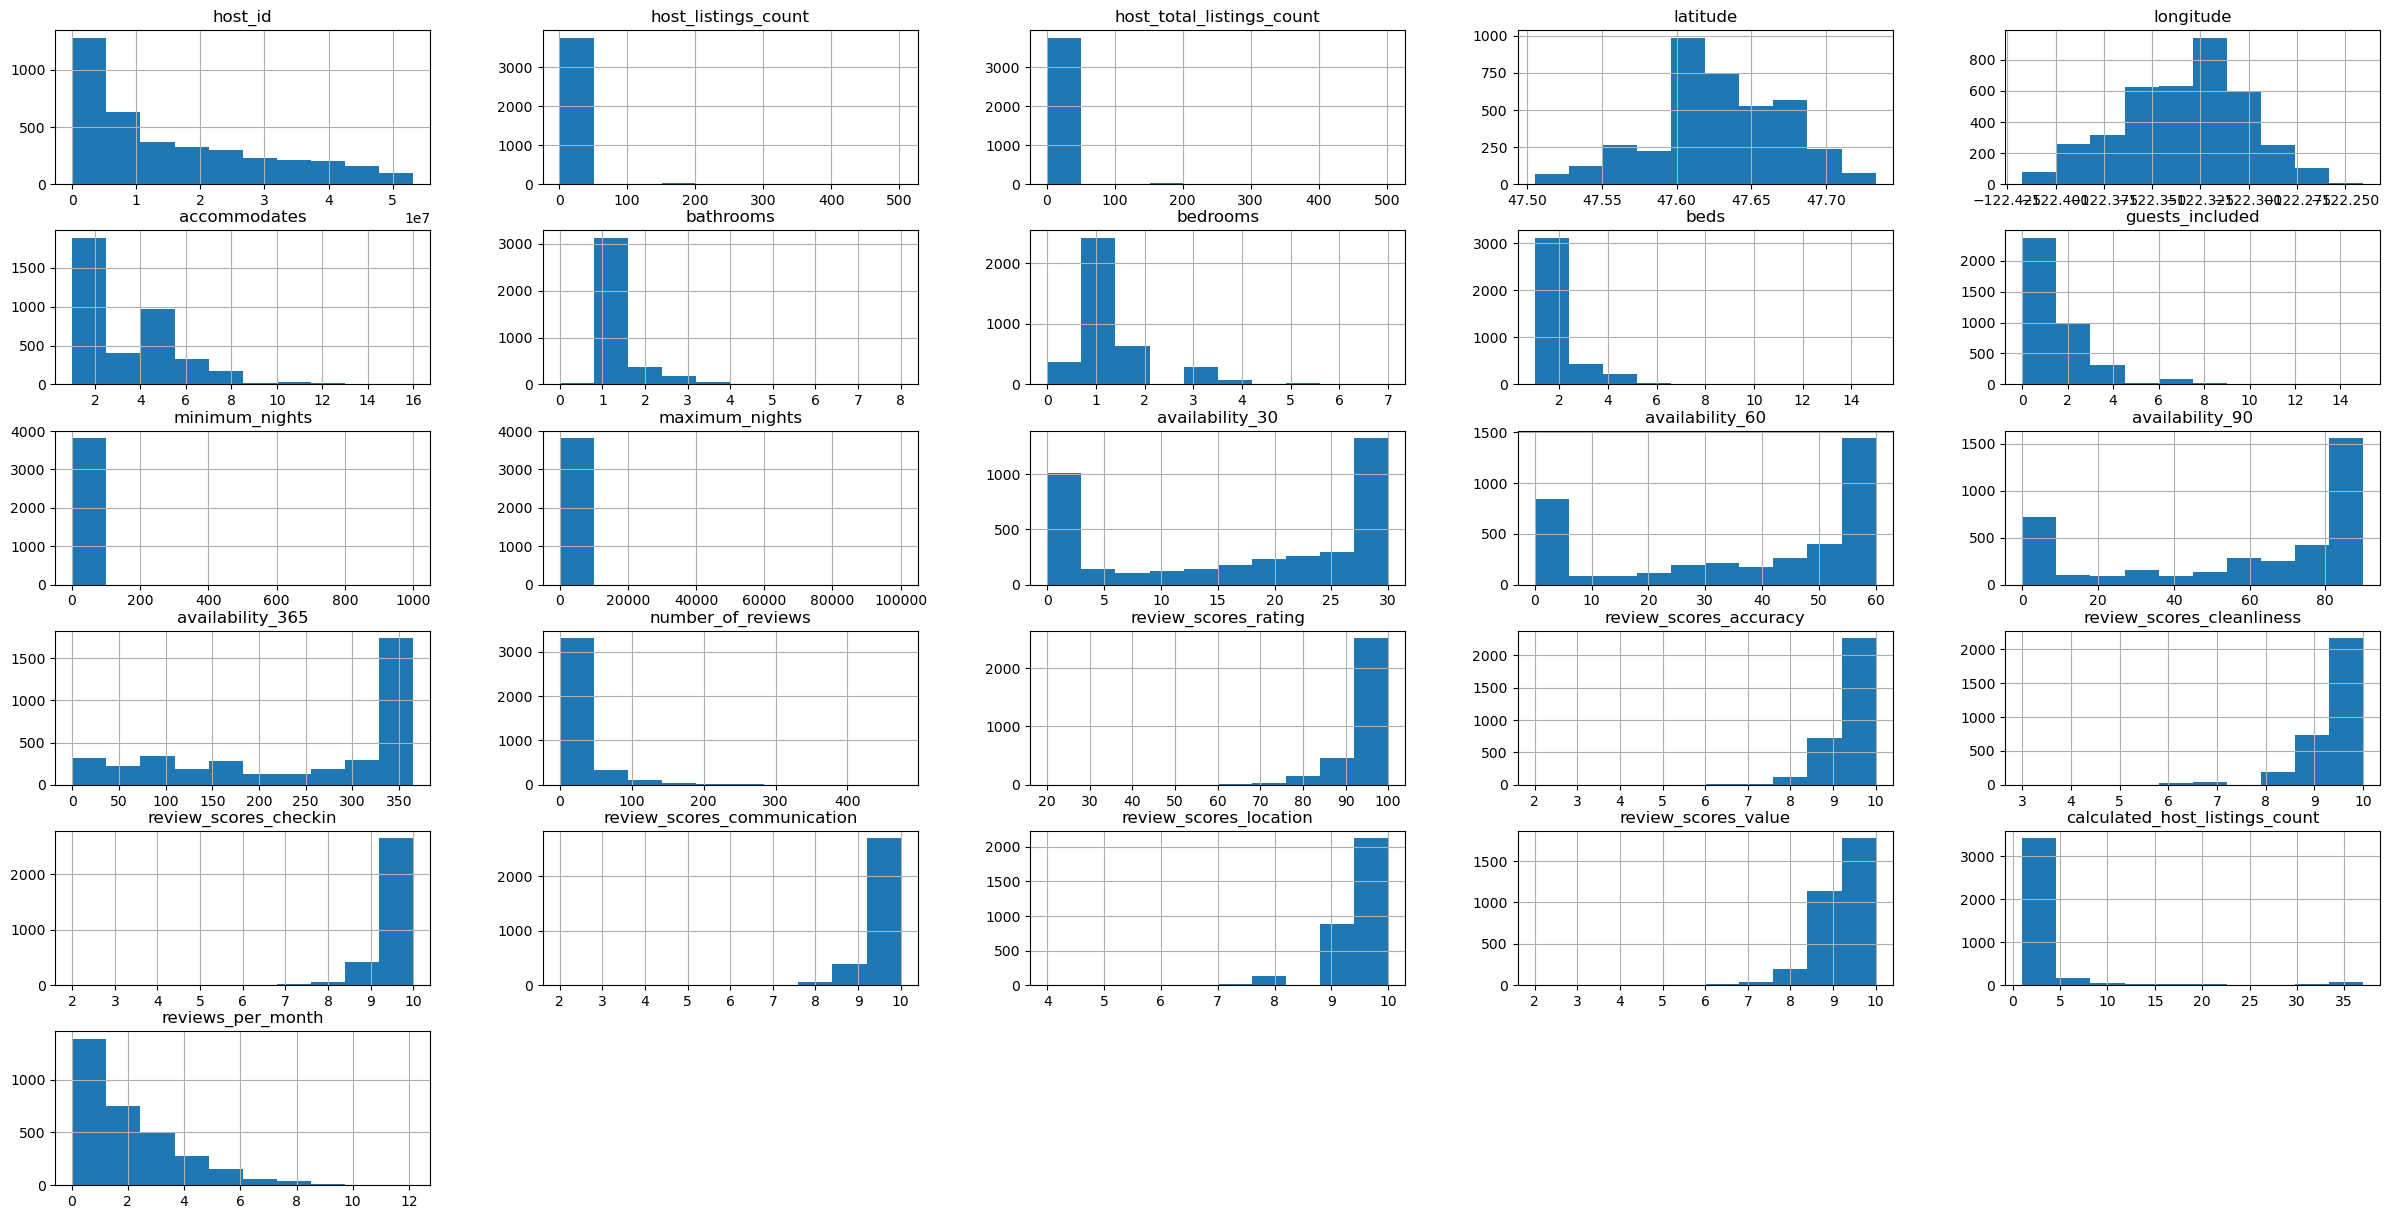

In [97]:
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
# visualise skewness
vals = listings[numeric_columns].hist(ax=ax)

In [98]:
# investigate any correlation
listings[(listings.host_listings_count==listings.host_total_listings_count) | (listings.host_listings_count.isna()&listings.host_total_listings_count.isna())].shape

(3818, 80)

**host_listings_count can be dropped**

In [99]:
listings.drop('host_listings_count', axis=1, inplace=True)
numeric_columns.remove('host_listings_count')

In [100]:
non_skewed = ['latitude', 'longitude', 'availability_30','availability_60', 'availability_90', 'availability_365']
# remove non skewed columns from numeric columns in order to avoid 
for col in non_skewed:
    numeric_columns.remove(col)

**Investigate Categorical Columns**

In [101]:
 # except date columns cleanse the strings
cat_columns = listings.select_dtypes(exclude=[np.number]).columns.tolist()
print(' | '.join(cat_columns))

last_scraped | name | summary | space | description | experiences_offered | neighborhood_overview | notes | transit | host_name | host_since | host_location | host_about | host_response_time | host_response_rate | host_acceptance_rate | host_is_superhost | host_neighbourhood | host_verifications | host_has_profile_pic | host_identity_verified | street | neighbourhood | neighbourhood_cleansed | neighbourhood_group_cleansed | city | state | zipcode | market | smart_location | country_code | country | is_location_exact | property_type | room_type | bed_type | amenities | price | weekly_price | monthly_price | security_deposit | cleaning_fee | extra_people | calendar_updated | has_availability | calendar_last_scraped | first_review | last_review | requires_license | jurisdiction_names | instant_bookable | cancellation_policy | require_guest_profile_picture | require_guest_phone_verification


In [102]:
listings[cat_columns].head(n=1)

,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_name,...,has_availability,calendar_last_scraped,first_review,last_review,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,Maija,...,t,2016-01-04,2011-11-01,2016-01-02,f,WASHINGTON,f,moderate,f,f


In [103]:

date_columns = ['first_review', 'last_review', 'host_since', 'last_scraped']

# convert date columns from object to datetime
for col in date_columns:
    listings[col] = pd.to_datetime(listings[col])

# instead of date columns use the calculated values for further analysis
listings['time_to_first_review'] = listings['first_review'] - listings['host_since']
listings['time_since_last_review'] = listings['last_scraped'] - listings['last_review']
listings.time_to_first_review = listings.time_to_first_review.dt.days
listings.time_since_last_review = listings.time_since_last_review.dt.days

# drop original columns
listings.drop(date_columns, axis=1, inplace=True)

# remove from categorical columns
for col in date_columns:
    cat_columns.remove(col)

In [104]:
# find columns that have only one value
non_unique_cat_counts  = listings[cat_columns].apply(lambda c : c.nunique()==1)
non_unique_columns = non_unique_cat_counts[non_unique_cat_counts==True].keys().tolist()
print(non_unique_columns)
# drop columns with single value for all records
listings.drop(non_unique_columns, axis=1, inplace=True)
# remove column names from cat_columns
for col in non_unique_columns:
    cat_columns.remove(col)

['experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']


In [105]:
high_dim_columns=['calendar_updated', 'neighborhood_overview','name','host_name', 'host_neighbourhood', 'host_location','host_verifications', 'neighbourhood', 'neighbourhood_cleansed','street','city', 'state','zipcode','smart_location']

listings.drop(columns=high_dim_columns, axis=1, inplace=True)

for col in high_dim_columns:
    cat_columns.remove(col)

In [106]:
listings[cat_columns].head(n=2)

,summary,space,description,notes,transit,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,"I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,...,$85.00,NaN,NaN,NaN,NaN,$5.00,f,moderate,f,f
1,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,...,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,f,strict,t,t


In [107]:
redundant_cols = ['summary', 'space', 'notes','host_about']
listings.drop(columns=redundant_cols, axis=1, inplace=True)
for col in redundant_cols:
    cat_columns.remove(col)

In [108]:
listings[cat_columns].head(n=2)

,description,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,...,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Make your self at home in this charming one-be...,NaN,within a few hours,96%,100%,f,t,t,Queen Anne,t,...,$85.00,NaN,NaN,NaN,NaN,$5.00,f,moderate,f,f
1,Chemically sensitive? We've removed the irrita...,"Convenient bus stops are just down the block, ...",within an hour,98%,100%,t,t,t,Queen Anne,t,...,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00,f,strict,t,t


last_scraped - host_since length of host
last scraped - last review latest review happened when
first_review - host_since first review happened when

**In fact the following fields can be numerical as they represent boolean values or have currency sign etc. in them.**

monetary = 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'

boolean = 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'has_availability', 'requires_license','instant_bookable','require_guest_profile_picture','require_guest_phone_verification'

In [109]:
rate_columns = ['host_response_rate', 'host_acceptance_rate']
monetary = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
boolean = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']

In [110]:
# cleanse monetary and rate columns from special characters and cast as integer
for col in monetary+rate_columns:
    listings[col] = listings[col].apply(lambda val: re.sub(r'[^a-zA-Z0-9]', '', str(val)) if val is not np.nan else 0).astype('int')
# encode boolean columns as 0-1
for col in boolean:
    listings[col] = listings[col].apply(lambda val: 1 if val=='t' else 0)

# remove columns that have been cast to integer    
for col in monetary+rate_columns+boolean:
    cat_columns.remove(col)

In [111]:
# Cleanse amenities and encode the column
listings =pd.concat([listings.drop('amenities',axis=1), listings.amenities.apply(lambda val: re.sub('[^a-zA-Z0-9\,]',' ', val).replace(' ','').split(',')).str.join('|').str.get_dummies()],axis=1)

In [112]:
cat_columns.remove('amenities')
for col in cat_columns:
    listings[col] = listings[col].apply(lambda val: re.sub('[^a-zA-Z0-9]', ' ', str(val)).strip(' '))

In [113]:
listings.head(n=2)

,description,transit,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,SafetyCard,Shampoo,SmokeDetector,SmokingAllowed,SuitableforEvents,TV,Washer,WasherDryer,WheelchairAccessible,WirelessInternet
0,Make your self at home in this charming one be...,nan,956883,within a few hours,96,100,0,3.0,1,1,...,0,0,0,0,0,1,1,0,0,1
1,Chemically sensitive We ve removed the irrita...,Convenient bus stops are just down the block ...,5177328,within an hour,98,100,1,6.0,1,1,...,1,0,1,0,0,1,1,0,0,1


In [114]:
# get polarities for description and transport
listings['description_polarity'] = listings['description'].apply(lambda val :  TextBlob(val).sentiment.polarity)
listings['transit_polarity'] = listings['transit'].apply(lambda val :  TextBlob(val).sentiment.polarity)

# remove original columns
listings.drop(columns=['description','transit'], axis=1, inplace=True)

In [115]:
listings.head(n=2)

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,...,SmokeDetector,SmokingAllowed,SuitableforEvents,TV,Washer,WasherDryer,WheelchairAccessible,WirelessInternet,description_polarity,transit_polarity
0,956883,within a few hours,96,100,0,3.0,1,1,Queen Anne,47.636289,...,0,0,0,1,1,0,0,1,0.232982,0.000000
1,5177328,within an hour,98,100,1,6.0,1,1,Queen Anne,47.639123,...,1,0,0,1,1,0,0,1,0.312738,-0.077778


In [116]:
obj_columns = listings.select_dtypes(exclude=[np.number]).columns.tolist()

In [117]:
obj_columns

['host_response_time',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [118]:
# get dummies for all object type columns
for col in obj_columns:
    listings[col] = listings[col].apply(lambda val: np.nan if val=='nan' else val)
    listings = pd.concat([listings.drop(col, axis=1), pd.get_dummies(listings[col], dummy_na=False ,drop_first=True)],axis=1)

In [119]:
listings.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,Treehouse,Yurt,Private room,Shared room,Couch,Futon,Pull out Sofa,Real Bed,moderate,strict
0,956883,96,100,0,3.0,1,1,47.636289,-122.371025,1,...,0,0,0,0,0,0,0,1,1,0
1,5177328,98,100,1,6.0,1,1,47.639123,-122.365666,1,...,0,0,0,0,0,0,0,1,0,1
2,16708587,67,100,0,2.0,1,1,47.629724,-122.369483,1,...,0,0,0,0,0,0,0,1,0,1
3,9851441,0,0,0,1.0,1,1,47.638473,-122.369279,1,...,0,0,0,0,0,0,0,1,0,0
4,1452570,100,0,0,2.0,1,1,47.632918,-122.372471,1,...,0,0,0,0,0,0,0,1,0,1


In [120]:
# drop any price related column from input
X = listings.drop(columns=['price','weekly_price','monthly_price'])
y = listings.price
# split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

In [121]:
for col in ['price','weekly_price','monthly_price']:
    monetary.remove(col)

# Prepare Training Data
X_train = X_train.fillna(X_train.mean())

# Remove skewness
X_train[numeric_columns+monetary+rate_columns] = X_train[numeric_columns+monetary+rate_columns].apply(lambda val: np.log(val+1))

scaler = StandardScaler()

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))
scaled_X_train.columns = X_train.columns


In [122]:
scaled_X_train.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,Treehouse,Yurt,Private room,Shared room,Couch,Futon,Pull out Sofa,Real Bed,moderate,strict
0,-0.784464,-2.487618,-1.974939,1.958453,-0.568245,0.048488,-1.895378,-0.175572,0.568435,0.342810,...,-0.027973,0.0,1.495986,-0.174987,-0.065718,-0.152315,-0.116063,0.219911,-0.695528,-0.768633
1,0.381840,-2.487618,-1.974939,-0.510607,-0.568245,0.048488,0.527599,1.121495,1.925694,0.342810,...,-0.027973,0.0,-0.668455,-0.174987,-0.065718,-0.152315,-0.116063,0.219911,1.437757,-0.768633
2,-0.120367,0.437528,0.506345,-0.510607,0.997541,0.048488,0.527599,-0.219013,0.316292,0.342810,...,-0.027973,0.0,-0.668455,-0.174987,-0.065718,-0.152315,-0.116063,0.219911,-0.695528,-0.768633
3,-1.715909,0.357360,0.506345,-0.510607,2.727307,0.048488,0.527599,-0.264045,-0.418062,-2.917069,...,-0.027973,0.0,-0.668455,-0.174987,-0.065718,-0.152315,-0.116063,0.219911,-0.695528,1.301012
4,0.250888,0.437528,0.506345,-0.510607,-0.110282,0.048488,0.527599,-0.642846,0.171519,0.342810,...,-0.027973,0.0,-0.668455,-0.174987,-0.065718,-0.152315,-0.116063,0.219911,1.437757,-0.768633


<Axes: >

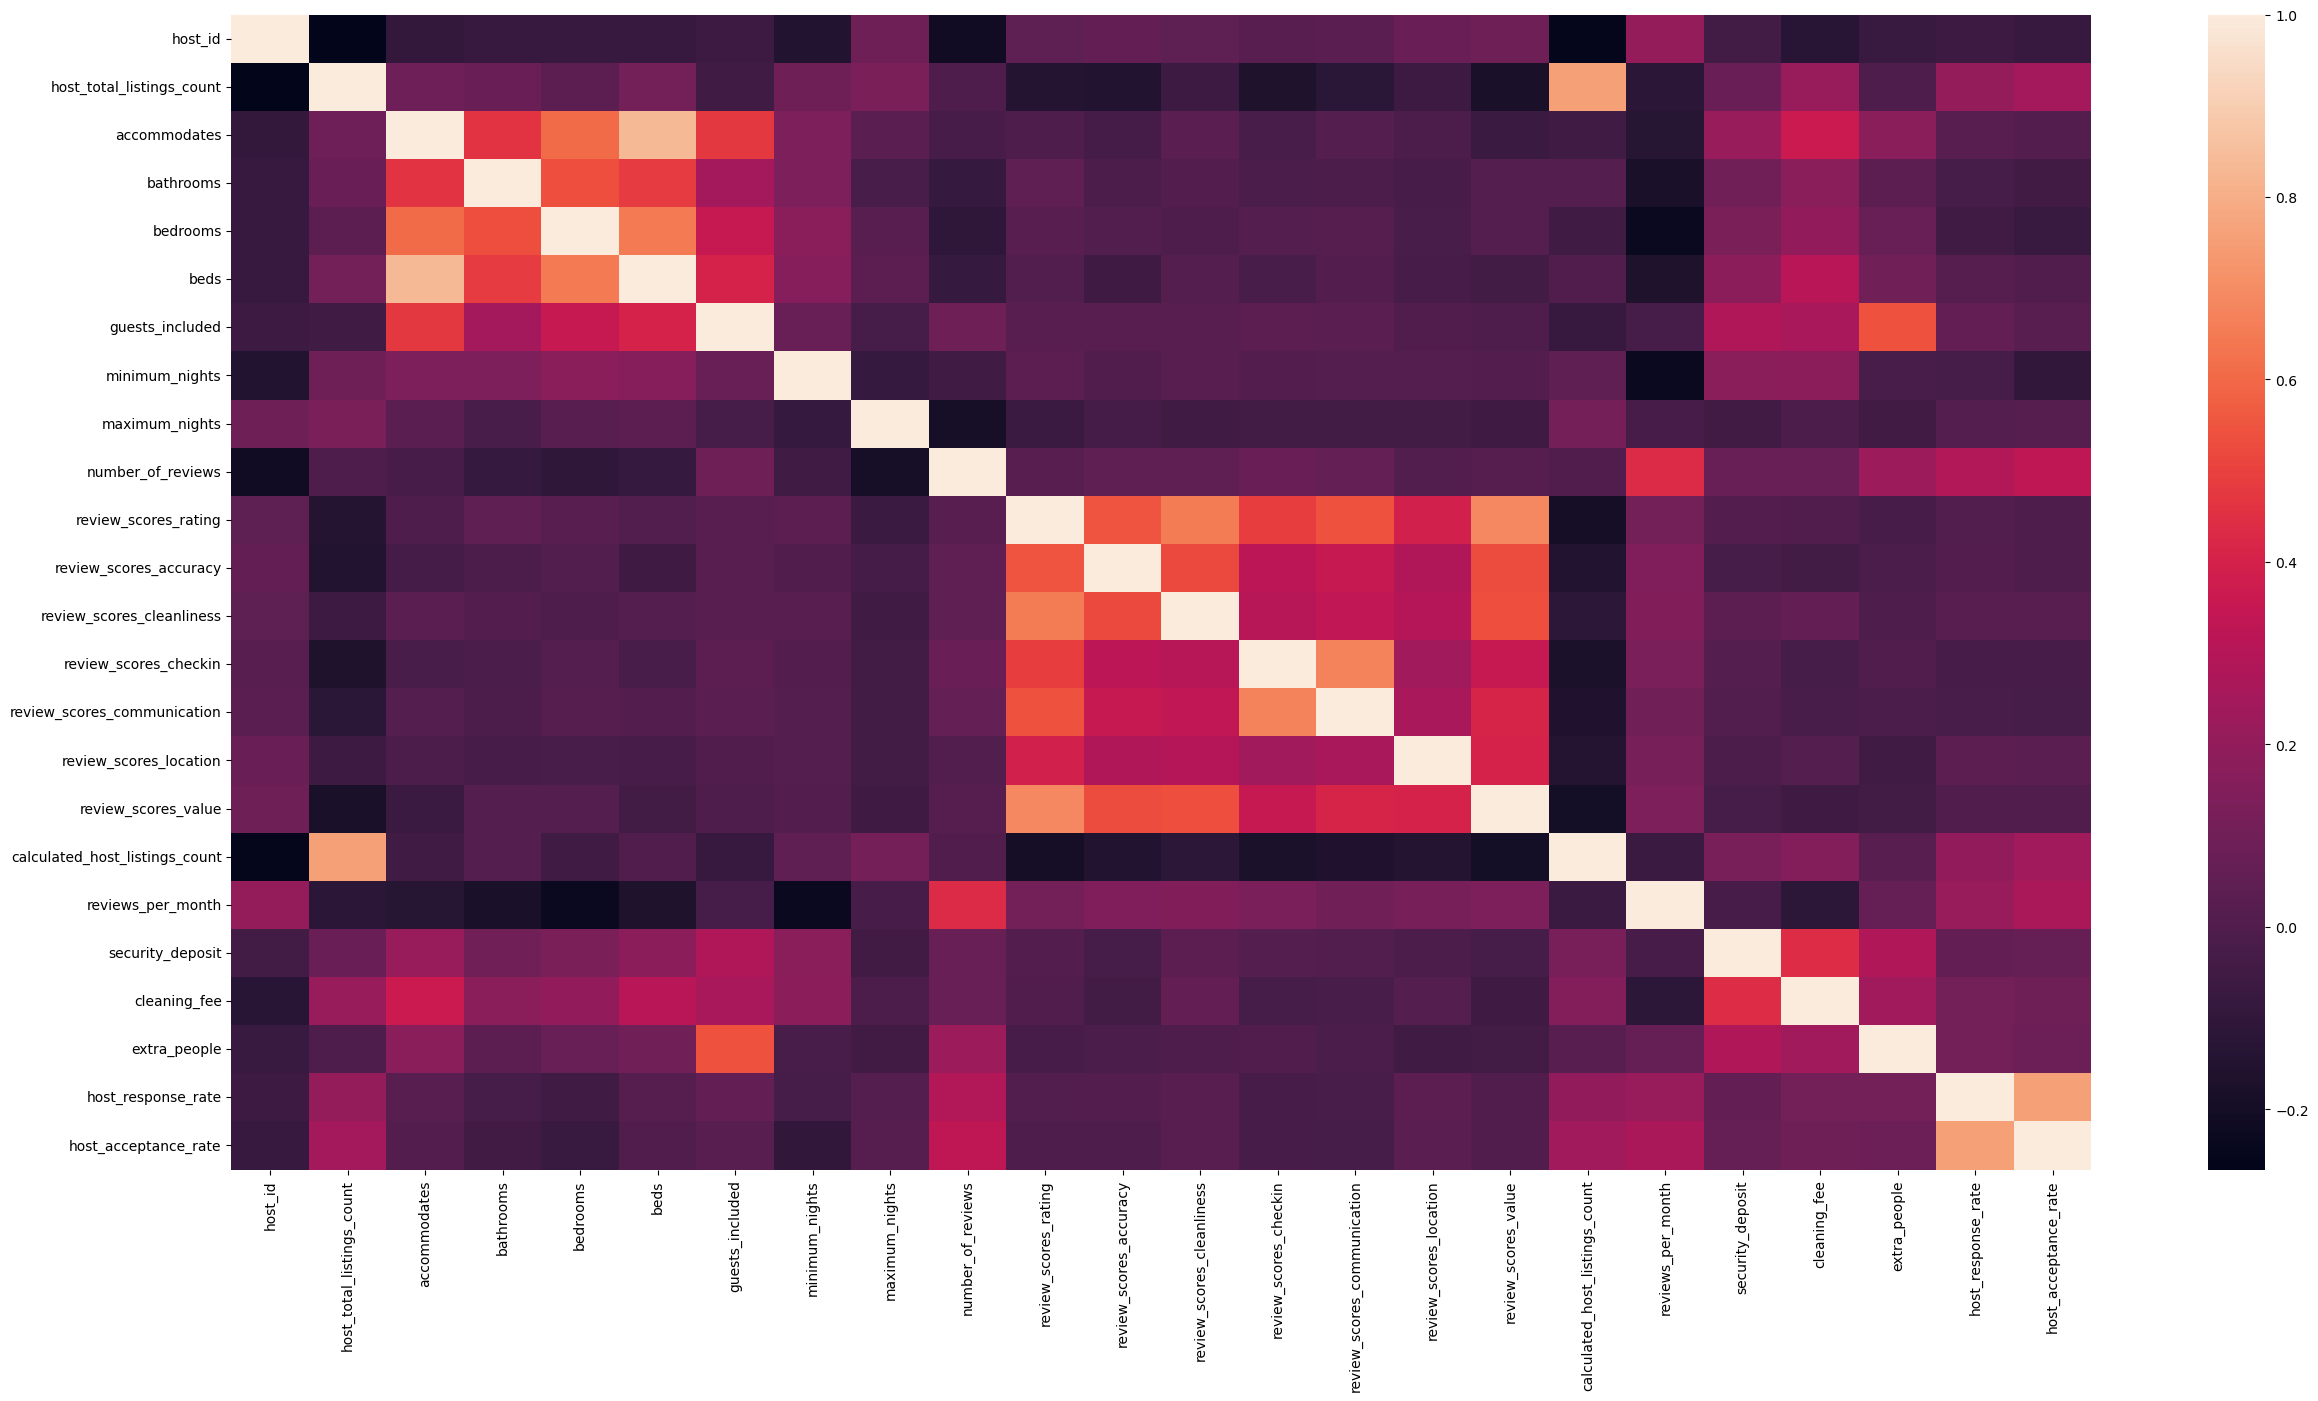

In [123]:
fig = plt.figure(figsize=(30,15))
ax = fig.gca()
sns.heatmap(scaled_X_train[numeric_columns+monetary+rate_columns].corr(), ax=ax)

In [124]:

# Remove skewness
X_test[numeric_columns+monetary+rate_columns] = X_test[numeric_columns+monetary+rate_columns].apply(lambda val: np.log(val+1))
# prepare Test Data for prediction
X_test = X_test.fillna(X_test.mean())

scaled_X_test = pd.DataFrame(scaler.transform(X_test))
scaled_X_test.columns = X_test.columns

In [125]:
scaled_X_train.shape

(2558, 124)

In [126]:
def fit_predict_and_calc_r2(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(r2_score(y_test, y_preds))

In [127]:
model = SVR(kernel='rbf', C=1.5, epsilon=0.2)
fit_predict_and_calc_r2(model, scaled_X_train, y_train, scaled_X_test, y_test)

-0.09607950302854529


In [128]:
model = RandomForestRegressor(n_estimators=310, max_depth=20, random_state=43)
fit_predict_and_calc_r2(model, scaled_X_train, y_train, scaled_X_test, y_test)

0.6344902175341355


In [129]:
model = ExtraTreesRegressor(n_estimators=100, random_state=37)
fit_predict_and_calc_r2(model, scaled_X_train, y_train, scaled_X_test, y_test)

0.5948717389669209


In [130]:
# chose performant regressor and get feature importances
model = RandomForestRegressor(n_estimators=310, max_depth=20, random_state=43)

fit_predict_and_calc_r2(model, scaled_X_train, y_train, scaled_X_test, y_test)

imps = pd.DataFrame()
imps['features'] = X_train.columns
imps['coefficients'] = model.feature_importances_
imps = imps.sort_values('coefficients', ascending=False)
imps.head(n=10)

0.6344902175341355


,features,coefficients
12,bedrooms,0.387329
15,cleaning_fee,0.049692
11,bathrooms,0.045103
10,accommodates,0.043270
116,Private room,0.030896
80,description_polarity,0.028932
7,latitude,0.025956
38,time_since_last_review,0.022395
23,availability_365,0.021425
36,reviews_per_month,0.020724
